# Multiscale Bone Enhancement Filtering
A small Python example to demonstrate the purpose of edge filtering.

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, ndimage

In [2]:
# Ignore stupid warnings
import warnings
warnings.filterwarnings('ignore')

## Simple Edge
We first consider a simple 1D signal from cortical bone. Our conceptual model is that the cortical bone is a `rect` function convolved with the PSF of our imaging system.

In [3]:
# Parameters of our 1D bone
t_s = 0.005             # Sampling period [mm] (distance between samples, voxel spacing)
thickness = 2.0         # Thickness of cortical bone[mm]
center = 3.0            # Center of cortical bone [mm]
amplitude = 1           # Signal amplitude [nominal units]

# Derived parameters
f_s = 1/t_s                     # Sampling frequency [1/mm]
start = (center-10*thickness)  # Where the signal starts
stop = (center+10*thickness)   # Where the signal ends
n = (stop - start)*f_s

# Create signal
x = np.linspace(start, stop, n)
bone = amplitude*np.where(abs(x-center)*2<=thickness, 1, 0)

In [4]:
# Create a function to plot our bone signal. Uses global variables: center, thickness, amplitude
def plot_bone(x, y, title='', xlabel='Position [mm]', ylabel='Response [nominal]', markers=True, estimated_points=None):
    # Plot signal
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    if markers:
        # Plot center and edges
        marker='o'
        markersize=3
        color="red"
        plt.plot(center, amplitude, marker=marker, markersize=markersize, color='black')
        plt.plot(center-thickness*0.5, 0.5*amplitude, marker=marker, markersize=markersize, color='red')
        plt.plot(center+thickness*0.5, 0.5*amplitude, marker=marker, markersize=markersize, color='red')
        
    if estimated_points:
        plt.plot(estimated_points[0], 0.5*amplitude, marker=marker, markersize=markersize, color='blue')
        plt.plot(estimated_points[1], 0.5*amplitude, marker=marker, markersize=markersize, color='blue')
        
    plt.show()

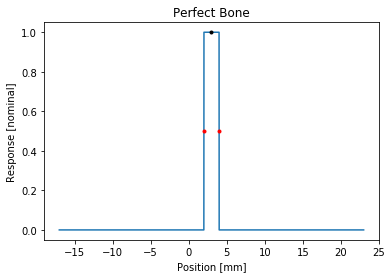

In [5]:
# Plot the created bone
plot_bone(x, bone, 'Perfect Bone')

### Convolution with a PSF
We now assume that we have introduced blur in our system. This is captured by convolving our input signal with the PSF of the imaging system. Here, we have assumed the PSF is a gaussian.

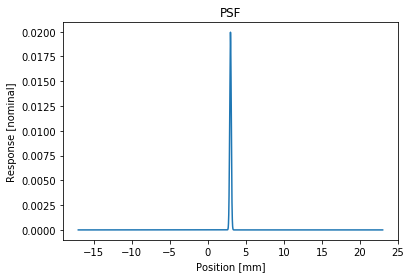

In [6]:
# Parameters of our PSF
std = 0.1     # Standard deviation [mm]

# Create signal
def gaussian_source(x, mean, std, n, diff=0, normalize=True):
    # Determine the normalization scale, if needed
    scale = 1
    g = np.exp((-1./2.) * np.square((x-mean)/std))
    g = g / (std*np.sqrt(2*np.pi))
    if normalize:
        g = g / np.sum(g.flatten())
        
    # Compute Gaussian from Hermite polynomials
    sigma_root_2 = std * np.sqrt(2)
    g = g * np.power(-1, diff) / np.power(1/sigma_root_2, diff)
    coef = np.zeros(diff+1)
    coef[diff] = 1
    g = g * np.polynomial.hermite_e.hermeval((x-mean)/sigma_root_2,coef)
    
    return g
psf = gaussian_source(x, center, std, n)
plot_bone(x, psf, 'PSF', markers=False)

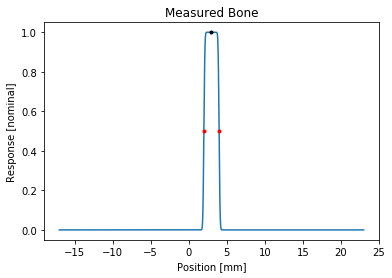

In [8]:
# Blur the data
blur_bone = np.convolve(bone, psf, mode='same')
plot_bone(x, blur_bone, 'Measured Bone')

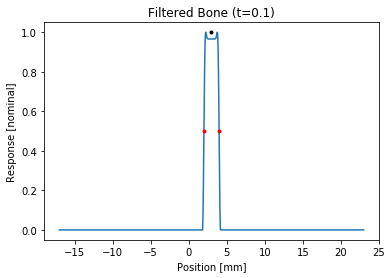

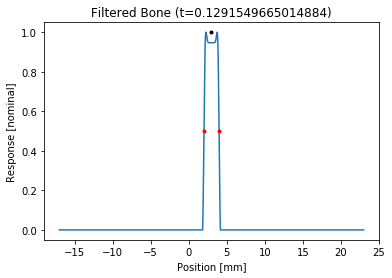

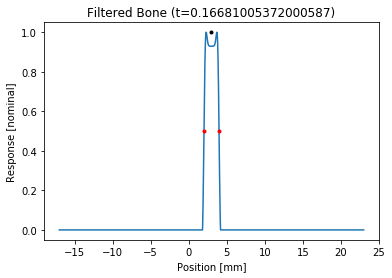

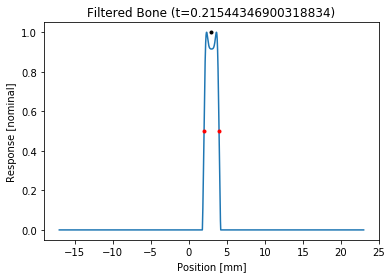

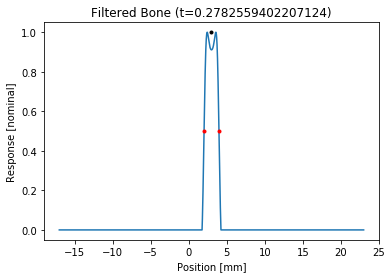

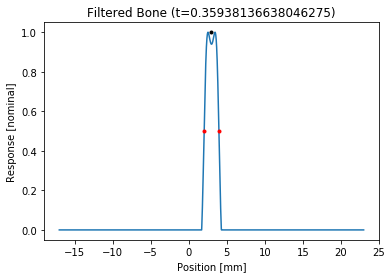

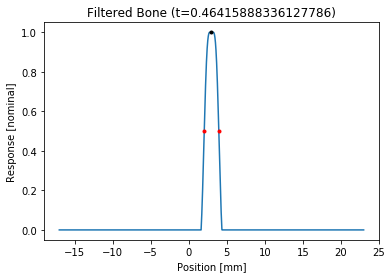

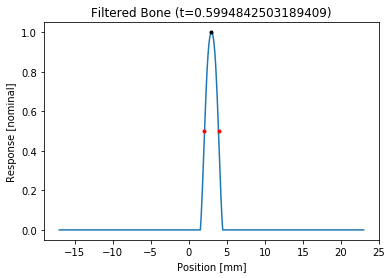

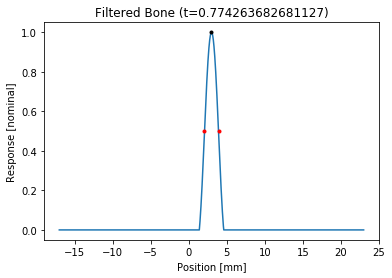

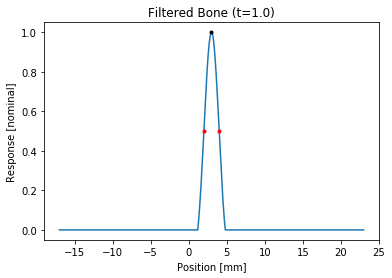

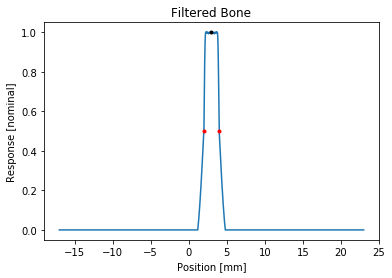

In [42]:
max_response_filtered_bone = np.zeros(x.shape[0])
for t in np.logspace(-1, 0, 10):
    probe_kernel = gaussian_source(x, center, t, n, diff=2, normalize=True)
    filtered_bone = np.convolve(blur_bone, probe_kernel, mode='same')
    filtered_bone = np.abs(filtered_bone) * (-filtered_bone > 0)
    filtered_bone = filtered_bone / np.max(filtered_bone)
    max_response_filtered_bone = np.maximum(max_response_filtered_bone, filtered_bone)
    plot_bone(x, filtered_bone, 'Filtered Bone (t={})'.format(t))
    plt.hold(True)
plot_bone(x, max_response_filtered_bone, 'Filtered Bone')
